# Data Challenge Description

The file data.csv contains several columns of information for your analysis. The data are synthetic but were constructed to mimic data that we observe from real-world satellite images.

The car.count column shows the number of cars observed in a parking lot for a retail location like a WalMart or Home Depot. The weather and cloud.indicator columns tell something about whether the parking lot was visible each day.

We would like you to do some exploration of the data, fit some simple models, and summarize what you find, with the goal of both describing the data included and being able to forecast future values. We have in mind this should take no more than a couple of hours.

We are interested to know what you find, but also how you go about finding it. What process? What methods? What intuitions did you use to guide your investigation? Why did you do "this" or "that."

*Please produce some output including plots and other results to explain what you find and how you did it. Don't worry too much about making the output and plots pretty -- well organized is good enough.

Please use any analysis tools and methods that you wish for this project as long as you can explain what each is doing and why you chose to use it. 


Some example questions to answer:

1) Summarize in a qualitative way what you see in the data when you first look it over. What does this suggest for your "plan of attack" for your analysis? What techniques might be appropriate and useful?

2) How would you characterize your findings quantitatively?

3) What additional analysis might be useful if you had a whole day to work on the problem?




Our team will review your work and get back to you. We may ask to schedule a follow-up call if we would like to further review your work with you on a video call.

# Table of Contents
[Feature Engineering](#cell1)
[Linear Regression](#cell2)
[Neural Networks](#cell3)
[Decision Tree Regression](#cell4)

In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from matplotlib import pyplot as plt
import numpy as np
import glob, re
import seaborn as sns
from datetime import datetime,date
np.random.seed(41)
import calendar
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

# Load and process the data

In [144]:
%%bash
ls data/

data.csv


In [145]:
data = pd.read_csv('data/data.csv')
data['date'] = pd.to_datetime(data['date'])
data['month.of.year'] = data['date'].dt.month
data['month.of.year'] = data['month.of.year'].apply(lambda x: calendar.month_name[x])
data['year'] = data['date'].dt.year
data['date']=data['date'].dt.date
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year
0,2010-01-01,Friday,101,0.1,clear,January,2010
1,2010-01-02,Saturday,34,0.2,cloudy,January,2010
2,2010-01-03,Sunday,113,0.4,clear,January,2010
3,2010-01-04,Monday,5,0.6,cloudy,January,2010
4,2010-01-05,Tuesday,124,0.1,clear,January,2010


In [146]:
data['date'] = pd.to_datetime(data['date'])
data['wom'] = data['date'].dt.day.apply(lambda d: (d-1) // 7 + 1)
data['day'] = data['month.of.year'] = data['date'].dt.day
data['date']=data['date'].dt.date
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day
0,2010-01-01,Friday,101,0.1,clear,1,2010,1,1
1,2010-01-02,Saturday,34,0.2,cloudy,2,2010,1,2
2,2010-01-03,Sunday,113,0.4,clear,3,2010,1,3
3,2010-01-04,Monday,5,0.6,cloudy,4,2010,1,4
4,2010-01-05,Tuesday,124,0.1,clear,5,2010,1,5


In [147]:
data.shape

(2373, 9)

We have single data point for all dates

In [148]:
data.isnull().values.any()

False

We don't have any missing values

In [149]:
nan_rows = data[data.isnull().T.any().T]
nan_rows

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day


In [150]:
print(data['date'].is_monotonic)
print(data.sample(frac=1)['date'].is_monotonic)
print(data['car.count'].is_monotonic)

True
False
False


<a id='cell1'></a>
## Extra feature engineering

In [151]:
data['indicator_change'] = pd.Series(data['cloud.indicator'].factorize()[0]).diff()*-1

In [152]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,indicator_change
0,2010-01-01,Friday,101,0.1,clear,1,2010,1,1,NaN
1,2010-01-02,Saturday,34,0.2,cloudy,2,2010,1,2,-1.0
2,2010-01-03,Sunday,113,0.4,clear,3,2010,1,3,1.0
3,2010-01-04,Monday,5,0.6,cloudy,4,2010,1,4,-1.0
4,2010-01-05,Tuesday,124,0.1,clear,5,2010,1,5,1.0


In [153]:
data = data.merge(right = data[['date','car.count']].loc[data['cloud.indicator']=='cloudy'].rolling(window=100).median().rename(columns={'car.count':'100_moving_ave_cloudy'}),
                  on='date',how='left')
data = data.merge(right = data[['date','car.count']].loc[data['cloud.indicator']=='clear'].rolling(window=100).median().rename(columns={'car.count':'100_moving_ave'}),
                  on='date',how='left')
data = data.fillna(method='ffill')
print(data.head())
data.tail()

         date day.of.week  car.count  weather cloud.indicator  month.of.year  \
0  2010-01-01      Friday        101      0.1           clear              1   
1  2010-01-02    Saturday         34      0.2          cloudy              2   
2  2010-01-03      Sunday        113      0.4           clear              3   
3  2010-01-04      Monday          5      0.6          cloudy              4   
4  2010-01-05     Tuesday        124      0.1           clear              5   

   year  wom  day  indicator_change  100_moving_ave_cloudy  100_moving_ave  
0  2010    1    1               NaN                    NaN             NaN  
1  2010    1    2              -1.0                    NaN             NaN  
2  2010    1    3               1.0                    NaN             NaN  
3  2010    1    4              -1.0                    NaN             NaN  
4  2010    1    5               1.0                    NaN             NaN  


,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,indicator_change,100_moving_ave_cloudy,100_moving_ave
2368,2016-06-26,Sunday,102,0.1,clear,26,2016,4,26,-0.0,53.5,112.5
2369,2016-06-27,Monday,38,0.6,cloudy,27,2016,4,27,-1.0,53.0,112.5
2370,2016-06-28,Tuesday,95,-1.6,clear,28,2016,4,28,1.0,53.0,112.0
2371,2016-06-29,Wednesday,104,-0.1,clear,29,2016,5,29,-0.0,53.0,112.0
2372,2016-06-30,Thursday,90,-0.3,cloudy,30,2016,5,30,-1.0,53.0,112.0


In [154]:
first_valid_index = data['100_moving_ave'].first_valid_index()
first_valid_index_cloudy = data['100_moving_ave_cloudy'].first_valid_index()
print(first_valid_index,first_valid_index_cloudy)


167 245


In [155]:
data = data[data.index>max(first_valid_index,first_valid_index_cloudy)]
data.reset_index(drop=True,inplace=True)
print(data.head())
data.tail()

         date day.of.week  car.count  weather cloud.indicator  month.of.year  \
0  2010-09-04    Saturday        145     -2.0           clear              4   
1  2010-09-05      Sunday        146      0.6           clear              5   
2  2010-09-06      Monday        148      1.0           clear              6   
3  2010-09-07     Tuesday        148     -0.2           clear              7   
4  2010-09-08   Wednesday         18     -1.0          cloudy              8   

   year  wom  day  indicator_change  100_moving_ave_cloudy  100_moving_ave  
0  2010    1    4               1.0                   67.5           126.5  
1  2010    1    5              -0.0                   67.5           127.0  
2  2010    1    6              -0.0                   67.5           127.5  
3  2010    1    7              -0.0                   67.5           128.0  
4  2010    2    8              -1.0                   67.5           128.0  


,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,indicator_change,100_moving_ave_cloudy,100_moving_ave
2122,2016-06-26,Sunday,102,0.1,clear,26,2016,4,26,-0.0,53.5,112.5
2123,2016-06-27,Monday,38,0.6,cloudy,27,2016,4,27,-1.0,53.0,112.5
2124,2016-06-28,Tuesday,95,-1.6,clear,28,2016,4,28,1.0,53.0,112.0
2125,2016-06-29,Wednesday,104,-0.1,clear,29,2016,5,29,-0.0,53.0,112.0
2126,2016-06-30,Thursday,90,-0.3,cloudy,30,2016,5,30,-1.0,53.0,112.0


In [156]:

data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,indicator_change,100_moving_ave_cloudy,100_moving_ave
0,2010-09-04,Saturday,145,-2.0,clear,4,2010,1,4,1.0,67.5,126.5
1,2010-09-05,Sunday,146,0.6,clear,5,2010,1,5,-0.0,67.5,127.0
2,2010-09-06,Monday,148,1.0,clear,6,2010,1,6,-0.0,67.5,127.5
3,2010-09-07,Tuesday,148,-0.2,clear,7,2010,1,7,-0.0,67.5,128.0
4,2010-09-08,Wednesday,18,-1.0,cloudy,8,2010,2,8,-1.0,67.5,128.0


In [157]:
data['car.count_substracted'] = data['car.count']-data['100_moving_ave']
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,indicator_change,100_moving_ave_cloudy,100_moving_ave,car.count_substracted
0,2010-09-04,Saturday,145,-2.0,clear,4,2010,1,4,1.0,67.5,126.5,18.5
1,2010-09-05,Sunday,146,0.6,clear,5,2010,1,5,-0.0,67.5,127.0,19.0
2,2010-09-06,Monday,148,1.0,clear,6,2010,1,6,-0.0,67.5,127.5,20.5
3,2010-09-07,Tuesday,148,-0.2,clear,7,2010,1,7,-0.0,67.5,128.0,20.0
4,2010-09-08,Wednesday,18,-1.0,cloudy,8,2010,2,8,-1.0,67.5,128.0,-110.0


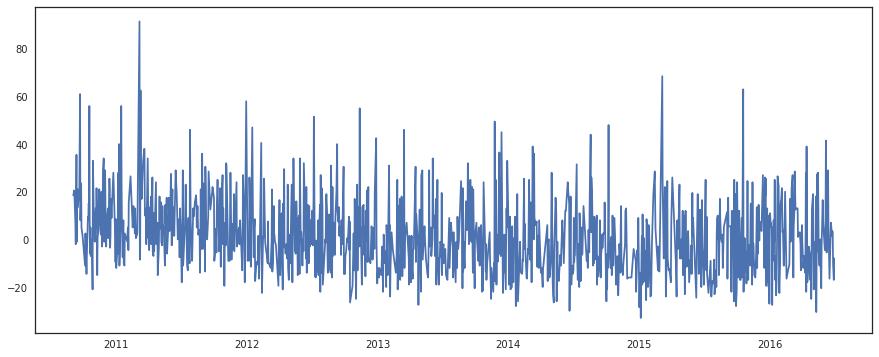

In [158]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear'),'date']
y = data.loc[(data['cloud.indicator']=='clear'),'car.count_substracted']
plt.plot(x,y)

In [159]:
data['count_consecutive_cloud.indicator'] = data.groupby((data['cloud.indicator'] != data['cloud.indicator'].shift(1)).cumsum()).cumcount()+1

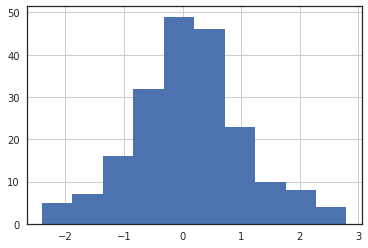

In [160]:
data[data['cloud.indicator']=='cloudy'].sort_values('car.count_substracted',ascending=False)[-200:]['weather'].hist()

## Does having a lot of back to back clear or cloudy days increase values?

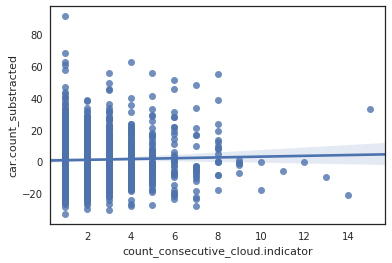

In [161]:
ax = sns.regplot(x='count_consecutive_cloud.indicator', y="car.count_substracted", data=data[data['cloud.indicator']=='clear'])

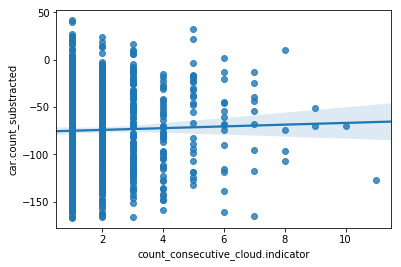

In [20]:
ax = sns.regplot(x='count_consecutive_cloud.indicator', y="car.count_substracted", data=data[data['cloud.indicator']=='cloudy'])

## Cloud indicator vs car count

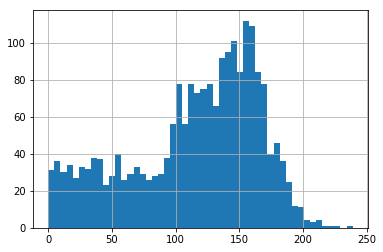

In [21]:
data['car.count'].hist(bins=50)

In [22]:
data['cloud.indicator'].unique()

array(['clear', 'cloudy'], dtype=object)

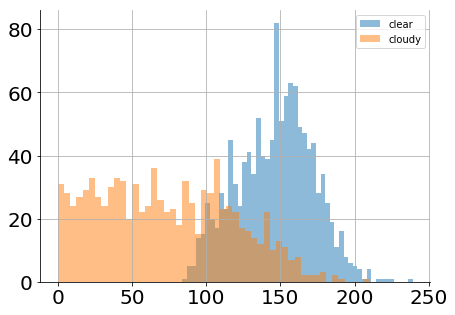

In [23]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[data['cloud.indicator']=='clear','car.count'].hist(bins=50,ax=ax,label='clear',alpha=0.5)
data.loc[data['cloud.indicator']=='cloudy','car.count'].hist(bins=50,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

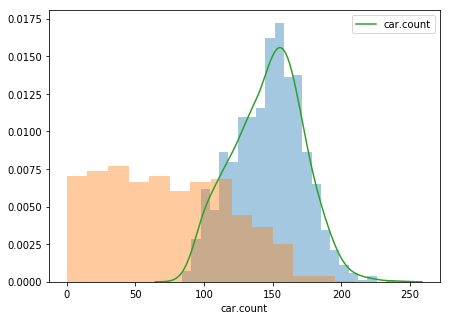

In [24]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
sns.distplot(data.loc[data['cloud.indicator']=='clear','car.count'],norm_hist=True,ax=ax,kde=False)
sns.distplot(data.loc[data['cloud.indicator']=='cloudy','car.count'],norm_hist=True,ax=ax,kde=False)
sns.kdeplot(data.loc[data['cloud.indicator']=='clear','car.count'],ax=ax,kernel='gau')

Clearly the distribution of car counts are very different if we have a cloudy day.

## Day of the week and month of the year vs car_count

(40, 100)

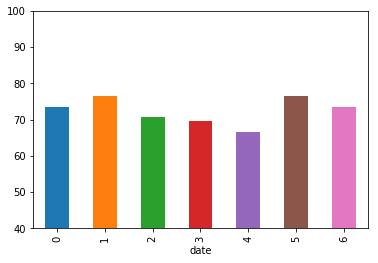

In [25]:
data[data['cloud.indicator']=='cloudy'].groupby(pd.to_datetime(data['date']).dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

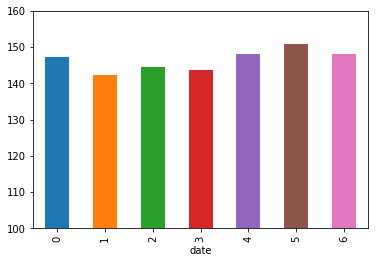

In [26]:
data[data['cloud.indicator']=='clear'].groupby(pd.to_datetime(data['date']).dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((100,160))

(100, 160)

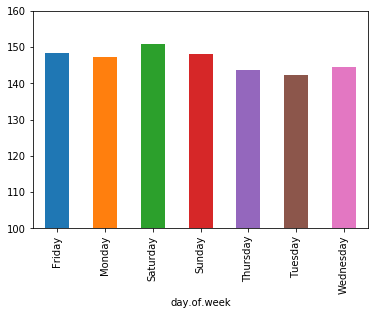

In [27]:
data[data['cloud.indicator']=='clear'].groupby('day.of.week')['car.count'].mean().plot.bar()
plt.ylim((100,160))

There doesn't seem to be a strong variation between weekdays

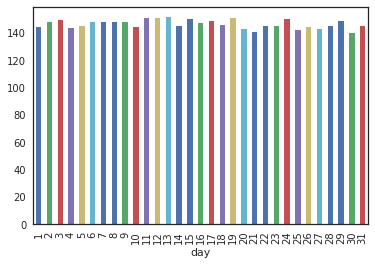

In [162]:
data[data['cloud.indicator']=='clear'].groupby('day')['car.count'].mean().plot.bar()

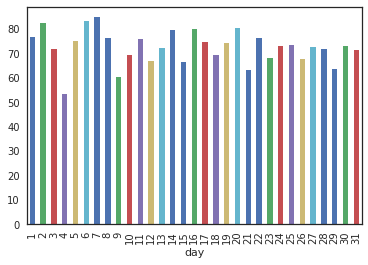

In [163]:
data[data['cloud.indicator']=='cloudy'].groupby('day')['car.count'].mean().plot.bar()

(40, 100)

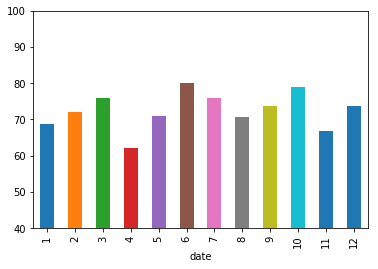

In [29]:
data[data['cloud.indicator']=='cloudy'].groupby(pd.to_datetime(data['date']).dt.month)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

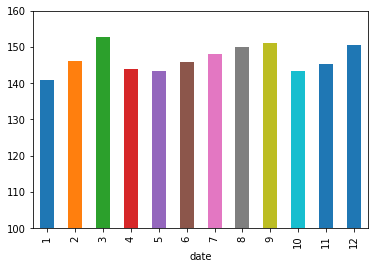

In [30]:
data[data['cloud.indicator']=='clear'].groupby(pd.to_datetime(data['date']).dt.month)['car.count'].mean().plot.bar()
plt.ylim((100,160))

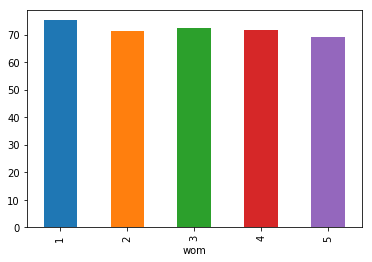

In [32]:
data[data['cloud.indicator']=='cloudy'].groupby('wom')['car.count'].mean().plot.bar()

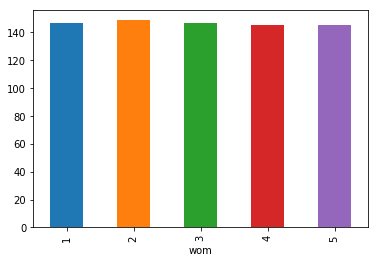

In [33]:
data[data['cloud.indicator']=='clear'].groupby('wom')['car.count'].mean().plot.bar()

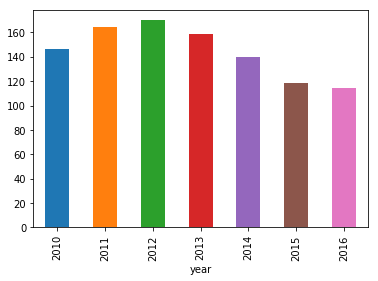

In [34]:
data[data['cloud.indicator']=='clear'].groupby('year')['car.count'].mean().plot.bar()
#plt.ylim((100,160))

Most likely there is recovery after financial crisis followed by retail apocalypse

## Weather vs car_count

In [35]:
data['weather'].unique()

array([-2. ,  0.6,  1. , -0.2, -1. , -0.8,  0. ,  1.9,  1.5, -0.1, -0.4,
       -1.4, -2.7,  1.4,  0.8,  0.1, -0.6,  0.9,  0.4, -0.5,  2. ,  1.2,
        0.2, -0.3, -1.2,  0.7,  0.5, -0.9,  1.1,  0.3,  2.6, -2.4,  3.2,
       -2.1, -0.7, -1.3, -1.5,  1.3, -1.6, -1.1,  1.8,  1.7, -2.9,  2.1,
        1.6, -2.3,  2.4, -1.7, -1.9,  2.3,  2.2, -2.5,  2.5, -3. , -1.8,
       -2.2,  2.7,  4.3,  3.1, -3.2,  3. ,  2.8, -3.1, -2.6,  3.3])

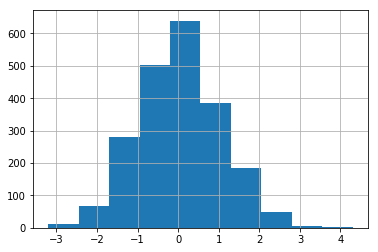

In [36]:
data['weather'].hist()

Looks like weather is a standard normal distribution

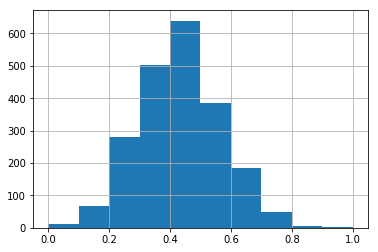

In [37]:
pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['weather'].values.reshape(-1, 1))[:,0],name='weather').hist()

### Is there a relationship between car.count and weather?

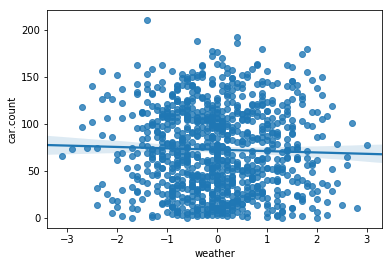

In [38]:
ax = sns.regplot(x="weather", y="car.count", data=data[data['cloud.indicator']=='cloudy'])

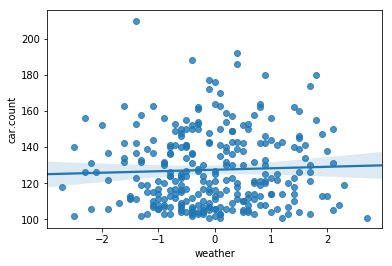

In [39]:
ax = sns.regplot(x="weather", y="car.count", data=data[(data['cloud.indicator']=='cloudy')&(data['car.count']>100)])

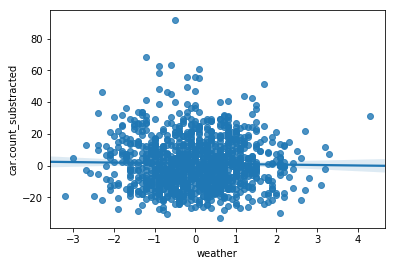

In [40]:
ax = sns.regplot(x="weather", y="car.count_substracted", data=data[data['cloud.indicator']=='clear'])

In [41]:
from scipy.stats import linregress
x = data.loc[data['cloud.indicator']=='clear','weather']
y = data.loc[data['cloud.indicator']=='clear','car.count']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

0.806111201613 146.528695019 0.0320716809452 0.265552456831 0.723696110953


In [42]:
x = data.loc[data['cloud.indicator']=='cloudy','weather']
y = data.loc[data['cloud.indicator']=='cloudy','car.count']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

-1.45989723203 72.4217391304 -0.0329161185196 0.318614938723 1.46304244859


There doesn't seem to be an significant relationship between weather and car count

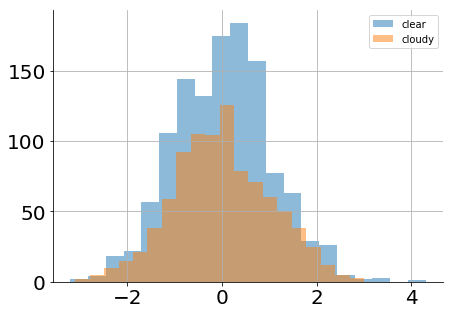

In [43]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='clear'),'weather'].hist(bins=20,ax=ax,label='clear',alpha=0.5)
data.loc[(data['cloud.indicator']=='cloudy'),'weather'].hist(bins=20,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

## Time vs car_count

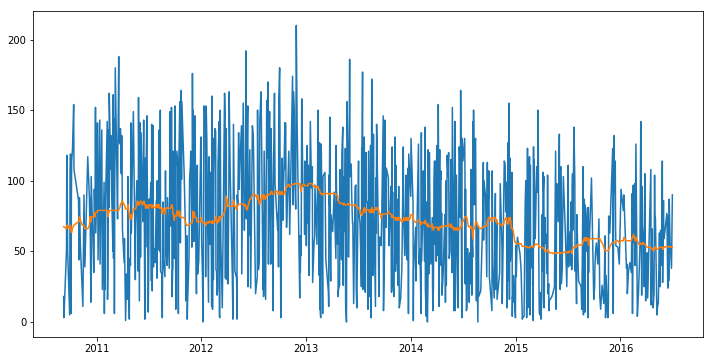

In [45]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='cloudy','date']
y = data.loc[data['cloud.indicator']=='cloudy','car.count']
plt.plot(x,y)
plt.plot(x,data.loc[data['cloud.indicator']=='cloudy','100_moving_ave_cloudy'])

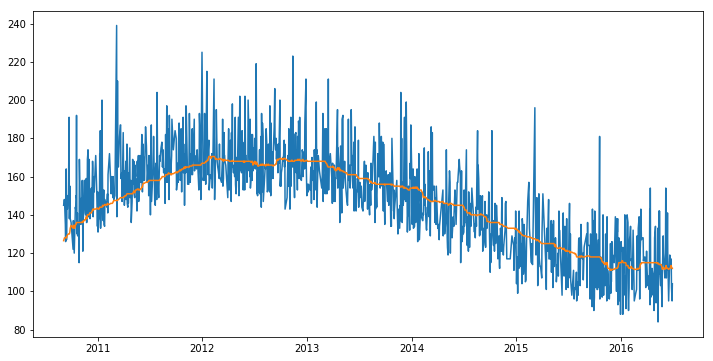

In [46]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='clear','date']
y = data.loc[data['cloud.indicator']=='clear','car.count']
plt.plot(x,y)
plt.plot(x,data.loc[data['cloud.indicator']=='clear','100_moving_ave'])

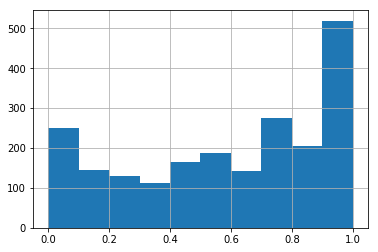

In [47]:
pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave'].values.reshape(-1, 1))[:,0],name='100_day_ave').hist()

# Are there oscillations within years?

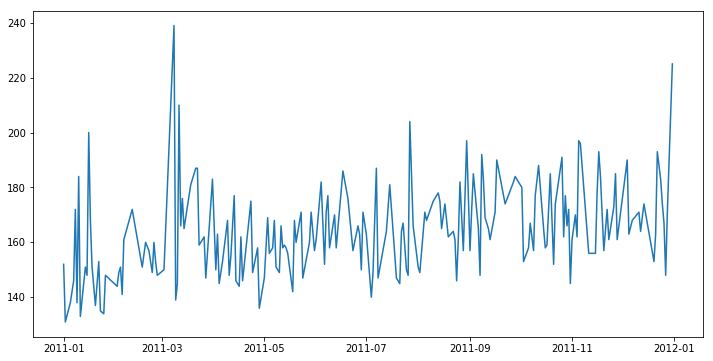

In [48]:
plt.figure(figsize=(12,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2011),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2011),'car.count']
plt.plot(x,y)

# Could indicator change be a reason for spikes?

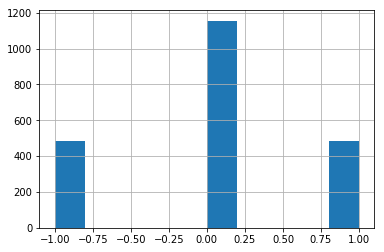

In [49]:
data['indicator_change'].hist()

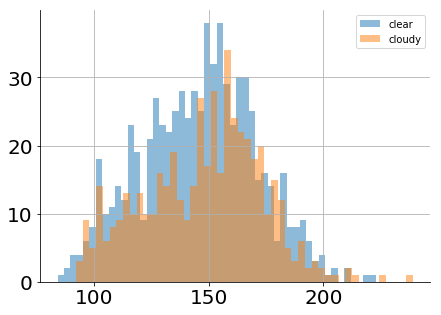

In [50]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='clear')&(data['indicator_change']==0),'car.count'].hist(bins=50,ax=ax,label='clear',alpha=0.5)
data.loc[(data['cloud.indicator']=='clear')&(data['indicator_change']==1),'car.count'].hist(bins=50,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

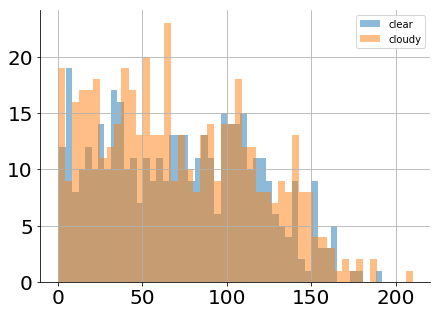

In [51]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='cloudy')&(data['indicator_change']==0),'car.count'].hist(bins=50,ax=ax,label='clear',alpha=0.5)
data.loc[(data['cloud.indicator']=='cloudy')&(data['indicator_change']==-1),'car.count'].hist(bins=50,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

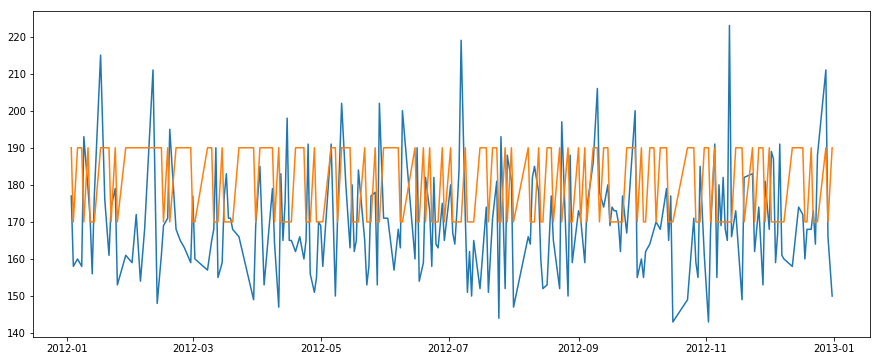

In [52]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'car.count']
z = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'indicator_change']
z = z*20+170
plt.plot(x,y)
plt.plot(x,z)

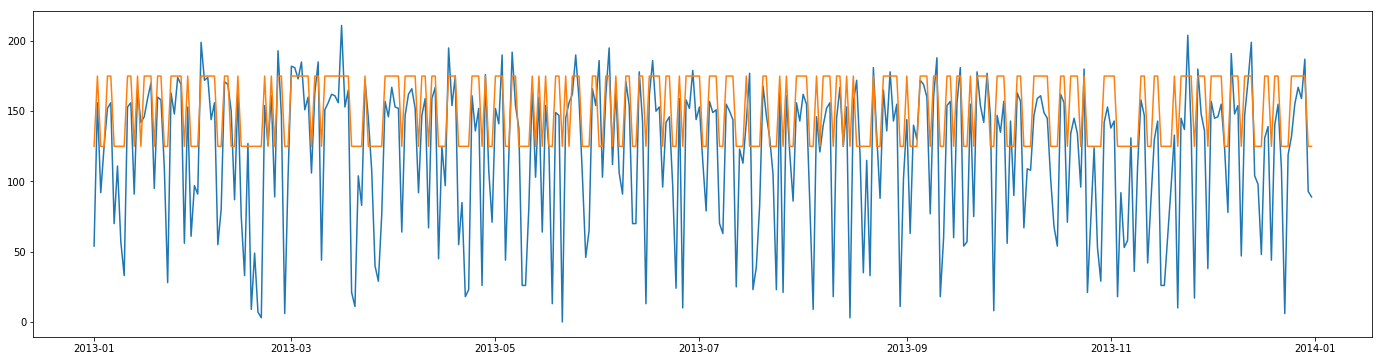

In [53]:
plt.figure(figsize=(24,6))
x = data.loc[(pd.to_datetime(data['date']).dt.year==2013),'date']
y = data.loc[(pd.to_datetime(data['date']).dt.year==2013),'car.count']
z = data.loc[(pd.to_datetime(data['date']).dt.year==2013),'cloud.indicator'].factorize()[0]
z = z*50+125
plt.plot(x,y)
plt.plot(x,z)

In [99]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,indicator_change,100_moving_ave_cloudy,100_moving_ave,car.count_substracted,count_consecutive_cloud.indicator
0,2010-09-04,Saturday,145,-2.0,clear,September,2010,1,1.0,67.5,126.5,18.5,1
1,2010-09-05,Sunday,146,0.6,clear,September,2010,1,-0.0,67.5,127.0,19.0,2
2,2010-09-06,Monday,148,1.0,clear,September,2010,1,-0.0,67.5,127.5,20.5,3
3,2010-09-07,Tuesday,148,-0.2,clear,September,2010,1,-0.0,67.5,128.0,20.0,4
4,2010-09-08,Wednesday,18,-1.0,cloudy,September,2010,2,-1.0,67.5,128.0,-110.0,1


In [100]:
data['100_moving_ave_interaction'] = data['100_moving_ave']*(data['cloud.indicator'].factorize()[0])


<a id='cell2'></a>
# Linear Regression

### Preprocessing steps for Linear Regression

In [199]:
X = pd.concat([pd.get_dummies(data[['day.of.week','month.of.year']]),
               pd.get_dummies(data['indicator_change'].astype(str)),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
              data[['car.count','date']],
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['weather'].values.reshape(-1, 1))[:,0],name='weather'),
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave'].values.reshape(-1, 1))[:,0],name='100_moving_ave'),
               pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave_cloudy'].values.reshape(-1, 1))[:,0],name='100_moving_ave'),
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['count_consecutive_cloud.indicator'].values.reshape(-1, 1))[:,0],name='count_consecutive_cloud.indicator')],
              axis=1)
X.head()

/home/eminozkan/.conda/envs/challenge/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,month.of.year,day.of.week_Friday,day.of.week_Monday,day.of.week_Saturday,day.of.week_Sunday,day.of.week_Thursday,day.of.week_Tuesday,day.of.week_Wednesday,-0.0,-1.0,1.0,cloud.indicator,car.count,date,weather,100_moving_ave,100_moving_ave,count_consecutive_cloud.indicator
0,4,0,0,1,0,0,0,0,0,0,1,0,145,2010-09-04,0.160000,0.260504,0.383838,0.000000
1,5,0,0,0,1,0,0,0,1,0,0,0,146,2010-09-05,0.506667,0.268908,0.383838,0.071429
2,6,0,1,0,0,0,0,0,1,0,0,0,148,2010-09-06,0.560000,0.277311,0.383838,0.142857
3,7,0,0,0,0,0,1,0,1,0,0,0,148,2010-09-07,0.400000,0.285714,0.383838,0.214286
4,8,0,0,0,0,0,0,1,0,1,0,1,18,2010-09-08,0.293333,0.285714,0.383838,0.000000


In [214]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

In [200]:
X.isnull().values.any()


False

In [197]:
X_train = X[X['date']<date(2015,1,1)]
X_valid = X[(date(2016,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

(1580, 18) (181, 18)


In [167]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Ridge regression

In [212]:
from sklearn.linear_model import Ridge

x = X_train.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_train['car.count']
clf = Ridge(alpha=100.0, 
            fit_intercept=True, 
            normalize=False, 
            copy_X=True, 
            max_iter=None, 
            tol=0.001, solver='auto', random_state=None)
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score for the mean model',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.611360211639
explained_variance_score 0.312141094652
explained_variance_score for the mean model -3.34732855983e+30
mean_absolute_error 24.087873225
mean_absolute_percentage_error 26.1343797721
mean_absolute_percentage_error for the mean model 35.224308531


In [217]:
x = X_valid.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',r2_score(x,y_true)) # this is R2 value
print('R2',r2_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score for the mean model',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

ValueError: y_true and y_pred have different number of output (153!=1)

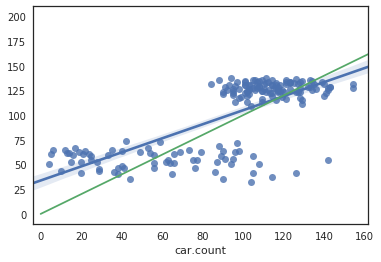

In [204]:
ax = sns.regplot(x=y_true, y=y_pred)
plt.plot([0,200],[0,200])

In [205]:
plt.figure(figsize=(15,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

# Lasso

In [110]:
from sklearn.linear_model import Lasso

x = X_train.drop(['date','car.count'],axis=1)
y_true = X_train['car.count']
clf = Lasso(alpha=1, fit_intercept=True, 
            normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, 
            warm_start=False, positive=False, random_state=None, selection='cyclic')
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.595331734197
explained_variance_score 0.227967075192
explained_variance_score -3.34732855983e+30
mean_absolute_error 24.7679129082
mean_absolute_percentage_error 26.5074363519
mean_absolute_percentage_error for the mean model 35.224308531


In [111]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.288115056547
explained_variance_score 0.469653959658
explained_variance_score -7.85816227532e+30
mean_absolute_error 29.1574237602
mean_absolute_percentage_error 30.7396349977
mean_absolute_percentage_error for the mean model 35.3861457353


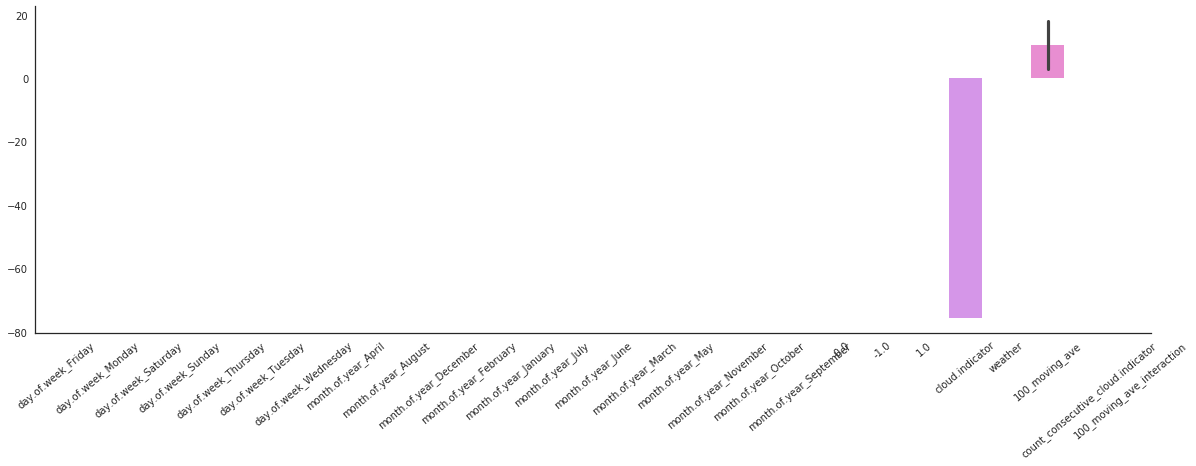

In [112]:
plt.figure(figsize=(20,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

# SVR

In [175]:
from sklearn.svm import SVR

x = X_train.drop(['date','car.count'],axis=1)
y_true = X_train['car.count']
clf = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=100, 
          epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value



R2 0.642024824636
explained_variance_score 0.356350798388
explained_variance_score -3.34732855983e+30
mean_absolute_error 21.9458037537
mean_absolute_percentage_error 24.1558588885
mean_absolute_percentage_error for the mean model 35.224308531


In [176]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.485704686081
explained_variance_score 0.464531383125
explained_variance_score -2.78021199291e+34
mean_absolute_error 20.2948575156
mean_absolute_percentage_error 31.1477213746
mean_absolute_percentage_error for the mean model 32.0616036824


In [ ]:
plt.figure(figsize=(20,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

<a id='cell3'></a>

# Neural Network

In [137]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout, Flatten, Dense,BatchNormalization, GaussianNoise, Activation
from keras import optimizers



train_set = X_train.drop(['date','car.count'],axis=1)
train_labels = X_train['car.count']
valid_set = X_valid.drop(['date','car.count'],axis=1)
valid_labels = X_valid['car.count']


# Create the model
model = Sequential()
model.add(Dense(28, input_shape=x.shape[1:]))
model.add(Dense(14, activation='relu'))
model.add(Dense(1, name='three'))
model.summary()

rms_optimizer = optimizers.RMSprop(lr=0.1)
model.compile(loss='mean_squared_error', optimizer=rms_optimizer)

weight_file = 'weights_best.hdf5'

checkpointer = ModelCheckpoint(filepath=weight_file,
                               verbose=1, save_best_only=True)

model.fit(train_set, train_labels,
                 validation_data=(valid_set, valid_labels),
                 epochs=20, batch_size=1024,
                 callbacks=[checkpointer], verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 28)                784       
_________________________________________________________________
dense_24 (Dense)             (None, 14)                406       
_________________________________________________________________
three (Dense)                (None, 1)                 15        
Total params: 1,205
Trainable params: 1,205
Non-trainable params: 0
_________________________________________________________________
Train on 1580 samples, validate on 181 samples
Epoch 1/20
Epoch 00001: val_loss improved from inf to 29290.00000, saving model to weights_best.hdf5
 - 0s - loss: 14910.4097 - val_loss: 29290.0000
Epoch 2/20
Epoch 00002: val_loss improved from 29290.00000 to 2459.65674, saving model to weights_best.hdf5
 - 0s - loss: 33412.6217 - val_loss: 2459.6567
Epoch 3/20
Epoch 00003: val_loss improved from 2459.6

In [138]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
model.load_weights(weight_file)
y_pred =  model.predict(valid_set)[:,0]
print('R2',r2_score(y_pred,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.27105490211
explained_variance_score 0.290661693825
explained_variance_score 0.0
mean_absolute_error 21.0602136475
mean_absolute_percentage_error 29.216107709
mean_absolute_percentage_error for the mean model 32.0616036824


# KNN

In [97]:
from sklearn.neighbors import KNeighborsRegressor

x = X_train.drop(['date','car.count'],axis=1)
y_true = X_train['car.count']
clf = KNeighborsRegressor(n_neighbors=20, 
                          weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', 
                          metric_params=None, n_jobs=1)
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.546334442386
explained_variance_score -0.11798512995
explained_variance_score -3.34732855983e+30
mean_absolute_error 26.2535126582
mean_absolute_percentage_error 26.2210424592
mean_absolute_percentage_error for the mean model 35.224308531


In [98]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.151674149696
explained_variance_score 0.130170524088
explained_variance_score -7.85816227532e+30
mean_absolute_error 29.788003663
mean_absolute_percentage_error 30.0169183323
mean_absolute_percentage_error for the mean model 35.3861457353


<a id='cell4'></a>

# Decision tree regression

In [ ]:
data.head()

## Preprocessing steps for decision tree regression

In [ ]:
X = pd.concat([pd.Series(data['month.of.year'].factorize()[0],name='month.of.year'),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
               pd.Series(data['day.of.week'].factorize()[0],name='day.of.week'),
              data[['car.count','date','weather','100_moving_ave','count_consecutive_cloud.indicator','indicator_change']]],axis=1)
X.head()

In [ ]:
X_train = X[X['date']<date(2015,1,1)]
X_valid = X[(date(2015,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

In [ ]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train.drop(['date','car.count'],axis=1),  X_train['car.count'])

lgb_eval = lgb.Dataset(X_valid.drop(['date','car.count'],axis=1),  X_valid['car.count'])

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mean_squared_error'},
    #'num_leaves': 8,
    'learning_rate': 0.1,
    'verbose': 50
}
print('Start training...')
# train
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                evals_result=evals_result,
                early_stopping_rounds=1)

In [ ]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = gbm.predict(x, num_iteration=gbm.best_iteration)
print('R2',r2_score(y_true,y_pred)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
lgb.plot_importance(gbm,ax=ax,importance_type='gain')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

# Conclusion:

I started by making sure that there are no missing values and the data is sorted on date. This is pretty important for time-series data. After EDA, I found that having a cloudy day impairs having an accurate estimate of car counts. There are weak variations in car counts depending on the day of the week or month of the year. I also did not find a correlation between weather and car counts. There was however strong long term trends when looking at years seperately, with the highest amount of cars present in 2012. I also constructed models in order to predict feature values of car counts. My initial models were really bad. However by including a 100 day moving median, I was able to capture long-term trends, and this significantly improved my models. I was able to obtain R2 value of around 0.4 in the validation data, which is not great, but it shows that we have a significant imporevement compared to a mean model. Looking for coefficients of both linear models and non-linear models we can see that the most important coefficient is cloud_indicator, and this makes sense. If it is cloudy there are less cars. The second most important coefficient is 100-day moving average, and the other coefficients have a very small role in terms of being able to predict the number of car counts.

Given more time I would:

1) Tune models; for example find the best regularization coefficients.
2) Try to work on identifying outliers by doing someting like bollinger bands or RSI (this was a question in my phone talk with Steve).
3) Include week of the month and see if this imporves the model (I doubt it)
4) Engineer another feature such as how many days back to back it was cloudy and clear etc. It could be that having a lot of cloudy or clear days together may change people's mood and they may visit a store more or less.